In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from my_utils import TissueRegistration
from skimage.util import view_as_blocks


ImportError: cannot import name 'TissueRegistration' from 'my_utils' (/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils.py)

In [ ]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm


***Loading the tissues and applying the mask***

In [ ]:
original_tissue='/nfs2/baos1/rudravg/GCA112TIA_DAPI_DAPI_30ms_ROUND_00_initial_reg.tif'
target_tissue='/nfs2/baos1/rudravg/GCA112TIA_DAPI_DAPI_12ms_ROUND_19_initial_reg.tif'
mask='/nfs2/baos1/rudravg/Retention_Masks/GCA112TIA_TISSUE_RETENTION.tif'
original_tissue=np.array(Image.open(original_tissue))
target_tissue=np.array(Image.open(target_tissue))
mask=np.array(Image.open(mask))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model='/home-local/rudravg/test_DAPI/epochs/epoch_35/epoch_35.pth'
recon_tissue=TissueRegistration(original_tissue, target_tissue, mask, model, device)
reconstructed_t=recon_tissue.process()

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(1675, 1589)


In [ ]:
reconstructed_t.shape

(1675, 1589)

In [6]:
original_tissue=original_tissue/255.
target_tissue=target_tissue/255.
mask=mask/255.
original_tissue=mask*original_tissue
target_tissue=mask*target_tissue

In [7]:
original_tissue.shape

(1675, 1589)

NameError: name 'original_tissue' is not defined

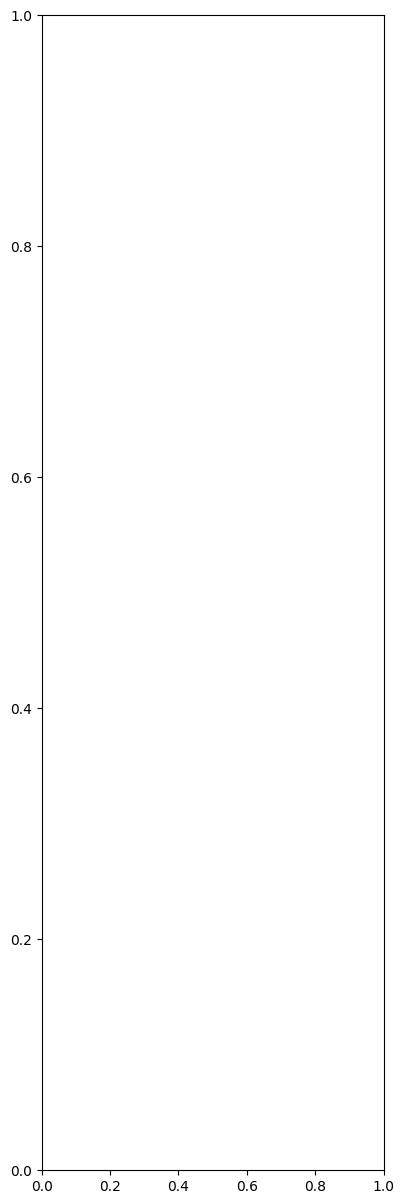

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(original_tissue, cmap='gray')
plt.title('Original Tissue')
plt.subplot(1,3,2)
plt.imshow(target_tissue, cmap='gray')
plt.title('Target Tissue')
plt.subplot(1,3,3)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

***Loading the model***

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
best_model_path='/home-local/rudravg/test_DAPI/epochs/epoch_35/epoch_35.pth'

In [22]:
best_model=vxm.networks.VxmDense.load(best_model_path, device)
best_model.to(device)
best_model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [ ]:
def registerTissues(original_tissue,target_tissue,model,device):
    block_size = (512, 512)
    num_blocks_x = original_tissue.shape[0] // block_size[0]
    num_blocks_y = original_tissue.shape[1] // block_size[1]
    original_tissue_cropped = original_tissue[:num_blocks_x * block_size[0], :num_blocks_y * block_size[1]]
    target_tissue_cropped = target_tissue[:num_blocks_x * block_size[0], :num_blocks_y * block_size[1]]
    original_tissue_blocks = view_as_blocks(original_tissue_cropped, block_shape=block_size)
    target_tissue_blocks = view_as_blocks(target_tissue_cropped, block_shape=block_size)
    pred_blocks = []

    for i in range (original_tissue_blocks.shape[0]):
        row_blocks = []
        for j in range (original_tissue_blocks.shape[1]):
            original_tissue_block = original_tissue_blocks[i, j]
            target_tissue_block = target_tissue_blocks[i, j]
            original_tissue_block = original_tissue_block[np.newaxis, ..., np.newaxis]
            target_tissue_block = target_tissue_block[np.newaxis, ..., np.newaxis]
            original_tissue_block=torch.from_numpy(original_tissue_block).to(device).float().permute(0,3,1,2)
            target_tissue_block=torch.from_numpy(target_tissue_block).to(device).float().permute(0,3,1,2)
            pred = model(original_tissue_block, target_tissue_block)
            row_blocks.append(pred[0].detach().cpu().numpy())
        pred_blocks.append(row_blocks)
    reconstructed_tissue = np.block(pred_blocks)
    reconstructed_tissue = reconstructed_tissue.squeeze().squeeze()
    reconstructed_tissue_padded = np.zeros(original_tissue.shape)
    reconstructed_tissue_padded[:reconstructed_tissue.shape[0], :reconstructed_tissue.shape[1]] = reconstructed_tissue




***Breaking the tissue into pieces and feeding it into the model***

In [23]:

block_size = (512, 512)

# Calculate the number of blocks that fit in the original size
num_blocks_x = original_tissue.shape[0] // block_size[0]
num_blocks_y = original_tissue.shape[1] // block_size[1]

# Crop the images to fit an exact number of blocks
original_tissue_cropped = original_tissue[:num_blocks_x * block_size[0], :num_blocks_y * block_size[1]]
target_tissue_cropped = target_tissue[:num_blocks_x * block_size[0], :num_blocks_y * block_size[1]]

# Break up the cropped images into pieces of 512x512
original_tissue_blocks = view_as_blocks(original_tissue_cropped, block_shape=block_size)
target_tissue_blocks = view_as_blocks(target_tissue_cropped, block_shape=block_size)

In [24]:
original_tissue_blocks.shape

(3, 3, 512, 512)

In [25]:
tissue_block=original_tissue_blocks[0,0]
tissue_block.shape

(512, 512)

In [26]:
tissue_block=tissue_block[np.newaxis,...,np.newaxis]  
tissue_block.shape

(1, 512, 512, 1)

In [27]:
pred_blocks = []

for i in range (original_tissue_blocks.shape[0]):
    row_blocks = []
    for j in range (original_tissue_blocks.shape[1]):
        original_tissue_block = original_tissue_blocks[i, j]
        target_tissue_block = target_tissue_blocks[i, j]
        original_tissue_block = original_tissue_block[np.newaxis, ..., np.newaxis]
        target_tissue_block = target_tissue_block[np.newaxis, ..., np.newaxis]
        original_tissue_block=torch.from_numpy(original_tissue_block).to(device).float().permute(0,3,1,2)
        target_tissue_block=torch.from_numpy(target_tissue_block).to(device).float().permute(0,3,1,2)
        pred = best_model(original_tissue_block, target_tissue_block)
        row_blocks.append(pred[0].detach().cpu().numpy())
    pred_blocks.append(row_blocks)
reconstructed_tissue = np.block(pred_blocks)
reconstructed_tissue = reconstructed_tissue.squeeze().squeeze()

In [28]:
#zero pad the reconstructed tissue to match the original size
reconstructed_tissue_padded = np.zeros(original_tissue.shape)
reconstructed_tissue_padded[:reconstructed_tissue.shape[0], :reconstructed_tissue.shape[1]] = reconstructed_tissue
reconstructed_tissue_padded.shape

(1675, 1589)

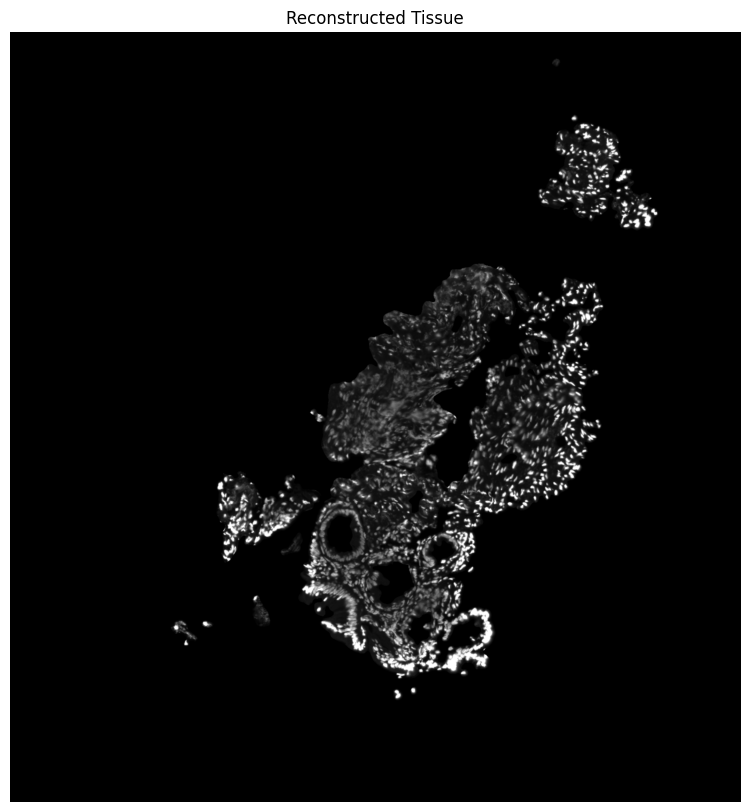

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.imshow(reconstructed_tissue_padded, cmap='gray')

plt.title('Reconstructed Tissue')

plt.axis('off')

plt.show()

In [33]:
def calculate_ncc(array1, array2):
    # Normalize the arrays
    array1 = (array1 - np.mean(array1)) / (np.std(array1) * len(array1))
    array2 = (array2 - np.mean(array2)) / (np.std(array2))

    # Calculate the cross-correlation
    ncc = np.correlate(array1, array2)

    return ncc

In [31]:
calculate_ncc(original_tissue.ravel(), reconstructed_tissue_padded.ravel())

array([0.96924691])

In [32]:
calculate_ncc(target_tissue.ravel(), reconstructed_tissue_padded.ravel())

array([0.78321438])

In [10]:
calculate_ncc(original_tissue.ravel(), target_tissue.ravel())

array([0.78828713])

In [12]:
calculate_ncc(original_tissue.ravel(), reconstructed_t.ravel())

array([0.89778181])

In [13]:
calculate_ncc(original_tissue.ravel(), target_tissue.ravel())

array([0.78828713])

In [14]:
calculate_ncc(target_tissue.ravel(), reconstructed_t.ravel())

array([0.90239413])